# Parallel Processing Demo 4: Performance Benchmarking & Best Practices

This notebook provides comprehensive benchmarking and guidelines for parallel processing:
- Systematic performance benchmarks for all parallel methods
- Scalability analysis (varying n_jobs)
- Task size impact on speedup
- Overhead analysis
- Best practices and decision framework

**Key Features Demonstrated:**
- ✅ Benchmark all 7 parallelized methods
- ✅ Scalability curves (n_jobs vs speedup)
- ✅ Efficiency analysis
- ✅ Optimal n_jobs recommendations
- ✅ Practical decision framework

## Setup and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from typing import Callable, Any

# py-tidymodels imports
from py_workflows import workflow
from py_parsnip import linear_reg, rand_forest
from py_recipes import recipe, all_numeric_predictors
from py_rsample import vfold_cv, initial_split, training, testing
from py_yardstick import metric_set, rmse, mae, r_squared
from py_tune import fit_resamples, tune_grid, grid_regular, tune
from py_workflowsets import WorkflowSet
from py_tune.parallel_utils import get_cpu_count

# Seaborn styling
sns.set_style('whitegrid')
sns.set_palette('husl')

print("All imports successful!")

All imports successful!


In [2]:
# Load data
raw_data = pd.read_csv('__data/preem.csv')
df = raw_data.copy()
df['date'] = pd.to_datetime(df['date'])

# Create train/test split
split = initial_split(df, prop=0.75, seed=123)
train_data = training(split)
test_data = testing(split)

print(f"Data shape: {df.shape}")
print(f"Training set: {train_data.shape[0]} rows")
print(f"Test set: {test_data.shape[0]} rows")

Data shape: (57, 10)
Training set: 42 rows
Test set: 15 rows


In [3]:
# System information
cpu_count = get_cpu_count()
print(f"\n✓ Detected {cpu_count} CPU cores")
print(f"✓ Joblib backend: loky (multiprocessing)")


✓ Detected 8 CPU cores
✓ Joblib backend: loky (multiprocessing)


In [4]:
# Define reusable components
FORMULA = "target ~ ."
metrics = metric_set(rmse, mae)

print(f"Formula: {FORMULA}")
print(f"Metrics: rmse, mae")

Formula: target ~ .
Metrics: rmse, mae


## Benchmarking Utility Functions

In [5]:
def benchmark_method(
    method_fn: Callable,
    *args,
    n_jobs_values: list = [1, 2, -1],
    **kwargs
) -> pd.DataFrame:
    """
    Benchmark a method across different n_jobs values.
    
    Returns DataFrame with columns: n_jobs, time, speedup, efficiency
    """
    results = []
    baseline_time = None
    
    for n_jobs in n_jobs_values:
        # Resolve -1 to actual CPU count
        actual_jobs = cpu_count if n_jobs == -1 else n_jobs
        
        # Run benchmark
        start = time.time()
        _ = method_fn(*args, **kwargs, n_jobs=n_jobs, verbose=False)
        elapsed = time.time() - start
        
        # Track baseline
        if n_jobs == 1:
            baseline_time = elapsed
        
        # Calculate metrics
        speedup = baseline_time / elapsed if baseline_time else 1.0
        efficiency = (speedup / actual_jobs * 100) if actual_jobs > 1 else 100.0
        
        results.append({
            'n_jobs': n_jobs,
            'actual_cores': actual_jobs,
            'time': elapsed,
            'speedup': speedup,
            'efficiency': efficiency
        })
    
    return pd.DataFrame(results)

print("✓ Benchmark utilities defined")

✓ Benchmark utilities defined


## Part 1: fit_resamples() Benchmarks

In [6]:
# Setup for fit_resamples
wf_simple = workflow().add_formula(FORMULA).add_model(linear_reg())
folds_5 = vfold_cv(train_data, v=5, seed=123)
folds_10 = vfold_cv(train_data, v=10, seed=123)

print("Benchmarking fit_resamples()...")
print("  Scenario 1: 5-fold CV")
print("  Scenario 2: 10-fold CV")

Benchmarking fit_resamples()...
  Scenario 1: 5-fold CV
  Scenario 2: 10-fold CV


In [7]:
# Benchmark 5-fold CV
bench_resample_5 = benchmark_method(
    fit_resamples,
    wf_simple, folds_5,
    metrics=metrics,
    n_jobs_values=[1, 2, -1]
)
bench_resample_5['scenario'] = '5-fold CV'

print("\n5-fold CV results:")
display(bench_resample_5)

/var/folders/_6/yhy5krgn18d9n4fzp832dpr00000gn/T/ipykernel_96522/85993474.py:21: UserWarning: n_jobs=8 is greater than task count (5). Only 5 worker(s) will be utilized. Consider using n_jobs=5 for efficiency.
  _ = method_fn(*args, **kwargs, n_jobs=n_jobs, verbose=False)



5-fold CV results:


,n_jobs,actual_cores,time,speedup,efficiency,scenario
0,1,1,0.084927,1.000000,100.000000,5-fold CV
1,2,2,1.146076,0.074102,3.705115,5-fold CV
2,-1,8,1.695222,0.050098,0.626222,5-fold CV


In [8]:
# Benchmark 10-fold CV
bench_resample_10 = benchmark_method(
    fit_resamples,
    wf_simple, folds_10,
    metrics=metrics,
    n_jobs_values=[1, 2, -1]
)
bench_resample_10['scenario'] = '10-fold CV'

print("\n10-fold CV results:")
display(bench_resample_10)


10-fold CV results:


,n_jobs,actual_cores,time,speedup,efficiency,scenario
0,1,1,0.108187,1.000000,100.000000,10-fold CV
1,2,2,1.324691,0.081670,4.083488,10-fold CV
2,-1,8,1.810614,0.059752,0.746896,10-fold CV


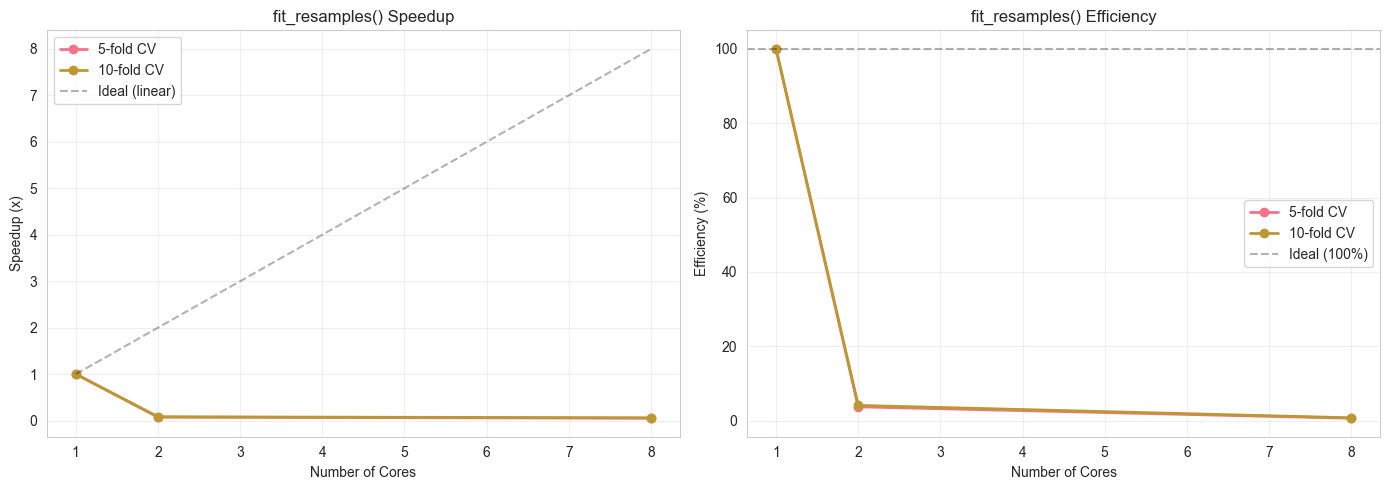

In [9]:
# Combine and visualize
bench_resample = pd.concat([bench_resample_5, bench_resample_10], ignore_index=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Speedup comparison
for scenario in ['5-fold CV', '10-fold CV']:
    data = bench_resample[bench_resample['scenario'] == scenario]
    ax1.plot(data['actual_cores'], data['speedup'], marker='o', label=scenario, linewidth=2)

ax1.plot([1, cpu_count], [1, cpu_count], 'k--', alpha=0.3, label='Ideal (linear)')
ax1.set_xlabel('Number of Cores')
ax1.set_ylabel('Speedup (x)')
ax1.set_title('fit_resamples() Speedup')
ax1.legend()
ax1.grid(alpha=0.3)

# Efficiency comparison
for scenario in ['5-fold CV', '10-fold CV']:
    data = bench_resample[bench_resample['scenario'] == scenario]
    ax2.plot(data['actual_cores'], data['efficiency'], marker='o', label=scenario, linewidth=2)

ax2.axhline(y=100, color='k', linestyle='--', alpha=0.3, label='Ideal (100%)')
ax2.set_xlabel('Number of Cores')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('fit_resamples() Efficiency')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Part 2: tune_grid() Benchmarks

In [10]:
# Setup for tune_grid
spec_tune = linear_reg(penalty=tune(), mixture=tune()).set_engine("sklearn")
wf_tune = workflow().add_formula(FORMULA).add_model(spec_tune)

param_info = {
    'penalty': {'range': (0.001, 1.0), 'trans': 'log'},
    'mixture': {'range': (0, 1)}
}

# Small grid (9 configs)
grid_small = grid_regular(param_info, levels=3)
# Medium grid (25 configs)
grid_medium = grid_regular(param_info, levels=5)

print("Benchmarking tune_grid()...")
print(f"  Scenario 1: 9 configs × 5 folds = {len(grid_small) * 5} fits")
print(f"  Scenario 2: 25 configs × 5 folds = {len(grid_medium) * 5} fits")

Benchmarking tune_grid()...
  Scenario 1: 9 configs × 5 folds = 45 fits
  Scenario 2: 25 configs × 5 folds = 125 fits


In [11]:
# Benchmark small grid
bench_tune_small = benchmark_method(
    tune_grid,
    wf_tune, folds_5,
    grid=grid_small,
    metrics=metrics,
    n_jobs_values=[1, 2, -1]
)
bench_tune_small['scenario'] = '9 configs'

print("\n9 configs × 5 folds results:")
display(bench_tune_small)


9 configs × 5 folds results:


,n_jobs,actual_cores,time,speedup,efficiency,scenario
0,1,1,0.452562,1.000000,100.000000,9 configs
1,2,2,1.513140,0.299088,14.954395,9 configs
2,-1,8,2.138927,0.211584,2.644795,9 configs


In [12]:
# Benchmark medium grid
bench_tune_medium = benchmark_method(
    tune_grid,
    wf_tune, folds_5,
    grid=grid_medium,
    metrics=metrics,
    n_jobs_values=[1, 2, -1]
)
bench_tune_medium['scenario'] = '25 configs'

print("\n25 configs × 5 folds results:")
display(bench_tune_medium)


25 configs × 5 folds results:


,n_jobs,actual_cores,time,speedup,efficiency,scenario
0,1,1,1.329424,1.000000,100.000000,25 configs
1,2,2,2.577705,0.515739,25.786966,25 configs
2,-1,8,3.384575,0.392789,4.909863,25 configs


/var/folders/_6/yhy5krgn18d9n4fzp832dpr00000gn/T/ipykernel_96522/2658932101.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_per_fit'] = data['time'] / n_fits
/var/folders/_6/yhy5krgn18d9n4fzp832dpr00000gn/T/ipykernel_96522/2658932101.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['time_per_fit'] = data['time'] / n_fits


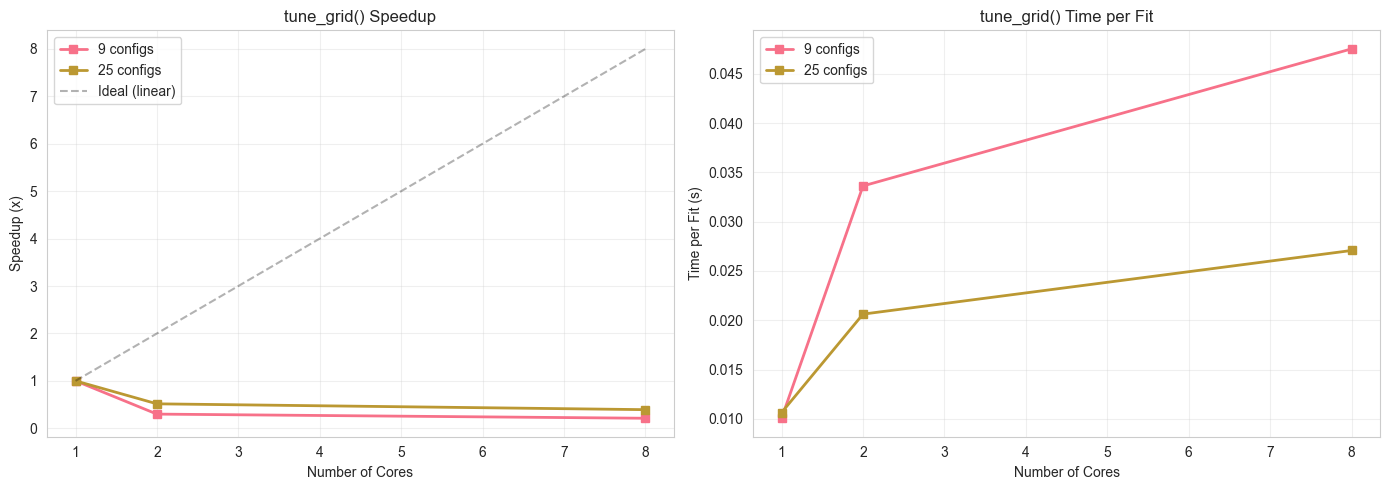

In [13]:
# Combine and visualize
bench_tune = pd.concat([bench_tune_small, bench_tune_medium], ignore_index=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Speedup comparison
for scenario in ['9 configs', '25 configs']:
    data = bench_tune[bench_tune['scenario'] == scenario]
    ax1.plot(data['actual_cores'], data['speedup'], marker='s', label=scenario, linewidth=2)

ax1.plot([1, cpu_count], [1, cpu_count], 'k--', alpha=0.3, label='Ideal (linear)')
ax1.set_xlabel('Number of Cores')
ax1.set_ylabel('Speedup (x)')
ax1.set_title('tune_grid() Speedup')
ax1.legend()
ax1.grid(alpha=0.3)

# Time per fit comparison
for scenario in ['9 configs', '25 configs']:
    data = bench_tune[bench_tune['scenario'] == scenario]
    n_fits = 45 if scenario == '9 configs' else 125
    data['time_per_fit'] = data['time'] / n_fits
    ax2.plot(data['actual_cores'], data['time_per_fit'], marker='s', label=scenario, linewidth=2)

ax2.set_xlabel('Number of Cores')
ax2.set_ylabel('Time per Fit (s)')
ax2.set_title('tune_grid() Time per Fit')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Part 3: Workflow.fit_nested() Benchmarks

In [14]:
# Create grouped data
df_grouped = train_data.copy()
n_groups_4 = 4
n_groups_8 = 8

regions_4 = ['North', 'South', 'East', 'West']
regions_8 = ['N', 'S', 'E', 'W', 'NE', 'NW', 'SE', 'SW']

df_grouped['group_4'] = [regions_4[i % n_groups_4] for i in range(len(df_grouped))]
df_grouped['group_8'] = [regions_8[i % n_groups_8] for i in range(len(df_grouped))]

wf_nested = workflow().add_formula(FORMULA).add_model(linear_reg())

print("Benchmarking fit_nested()...")
print(f"  Scenario 1: {n_groups_4} groups")
print(f"  Scenario 2: {n_groups_8} groups")

Benchmarking fit_nested()...
  Scenario 1: 4 groups
  Scenario 2: 8 groups


In [15]:
# Benchmark 4 groups
bench_nested_4 = benchmark_method(
    wf_nested.fit_nested,
    df_grouped,
    group_col='group_4',
    n_jobs_values=[1, 2, -1]
)
bench_nested_4['scenario'] = '4 groups'

print("\n4 groups results:")
display(bench_nested_4)

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_workflows/workflow.py:792: UserWarning: per_group_prep=True requires a recipe preprocessor. Workflow uses formula-only preprocessing. Falling back to per_group_prep=False.
  warnings.warn(
/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_workflows/workflow.py:792: UserWarning: per_group_prep=True requires a recipe preprocessor. Workflow uses formula-only preprocessing. Falling back to per_group_prep=False.
  warnings.warn(


NotImplementedError: Sorry, pickling not yet supported. See https://github.com/pydata/patsy/issues/26 if you want to help.

In [16]:
# Benchmark 8 groups
bench_nested_8 = benchmark_method(
    wf_nested.fit_nested,
    df_grouped,
    group_col='group_8',
    n_jobs_values=[1, 2, -1]
)
bench_nested_8['scenario'] = '8 groups'

print("\n8 groups results:")
display(bench_nested_8)

/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_workflows/workflow.py:792: UserWarning: per_group_prep=True requires a recipe preprocessor. Workflow uses formula-only preprocessing. Falling back to per_group_prep=False.
  warnings.warn(


NotImplementedError: Sorry, pickling not yet supported. See https://github.com/pydata/patsy/issues/26 if you want to help.

In [ ]:
# Combine and visualize
bench_nested = pd.concat([bench_nested_4, bench_nested_8], ignore_index=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Speedup comparison
for scenario in ['4 groups', '8 groups']:
    data = bench_nested[bench_nested['scenario'] == scenario]
    ax1.plot(data['actual_cores'], data['speedup'], marker='^', label=scenario, linewidth=2)

ax1.plot([1, cpu_count], [1, cpu_count], 'k--', alpha=0.3, label='Ideal (linear)')
ax1.set_xlabel('Number of Cores')
ax1.set_ylabel('Speedup (x)')
ax1.set_title('fit_nested() Speedup')
ax1.legend()
ax1.grid(alpha=0.3)

# Efficiency comparison
for scenario in ['4 groups', '8 groups']:
    data = bench_nested[bench_nested['scenario'] == scenario]
    ax2.plot(data['actual_cores'], data['efficiency'], marker='^', label=scenario, linewidth=2)

ax2.axhline(y=100, color='k', linestyle='--', alpha=0.3, label='Ideal (100%)')
ax2.set_xlabel('Number of Cores')
ax2.set_ylabel('Efficiency (%)')
ax2.set_title('fit_nested() Efficiency')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Part 4: WorkflowSet Benchmarks

In [19]:
# Create small and large WorkflowSets
formulas = ["target ~ ."]
recipes_list = [
    recipe().step_normalize(all_numeric_predictors()),
    recipe().step_normalize(all_numeric_predictors()).step_pca(all_numeric_predictors(), num_comp=3)
]
models = [linear_reg(), rand_forest(trees=50).set_mode('regression')]

# Small: 1 formula × 2 models = 2 workflows
wf_set_small = WorkflowSet.from_cross(preproc=formulas, models=models)

# Large: 3 preprocessing × 2 models = 6 workflows
wf_set_large = WorkflowSet.from_cross(preproc=formulas + recipes_list, models=models)

print("Benchmarking WorkflowSet.fit_resamples()...")
print(f"  Scenario 1: {len(wf_set_small.workflows)} workflows × 5 folds = {len(wf_set_small.workflows) * 5} fits")
print(f"  Scenario 2: {len(wf_set_large.workflows)} workflows × 5 folds = {len(wf_set_large.workflows) * 5} fits")

Benchmarking WorkflowSet.fit_resamples()...
  Scenario 1: 2 workflows × 5 folds = 10 fits
  Scenario 2: 6 workflows × 5 folds = 30 fits


In [20]:
# Benchmark small WorkflowSet
bench_wfset_small = benchmark_method(
    wf_set_small.fit_resamples,
    resamples=folds_5,
    metrics=metrics,
    n_jobs_values=[1, 2, -1]
)
bench_wfset_small['scenario'] = '2 workflows'

print("\n2 workflows × 5 folds results:")
display(bench_wfset_small)

/var/folders/_6/yhy5krgn18d9n4fzp832dpr00000gn/T/ipykernel_96522/85993474.py:21: UserWarning: n_jobs=8 is greater than task count (2). Only 2 worker(s) will be utilized. Consider using n_jobs=2 for efficiency.
  _ = method_fn(*args, **kwargs, n_jobs=n_jobs, verbose=False)



2 workflows × 5 folds results:


,n_jobs,actual_cores,time,speedup,efficiency,scenario
0,1,1,0.260390,1.000000,100.000000,2 workflows
1,2,2,1.392766,0.186959,9.347936,2 workflows
2,-1,8,1.498457,0.173772,2.172150,2 workflows


In [21]:
# Benchmark large WorkflowSet
bench_wfset_large = benchmark_method(
    wf_set_large.fit_resamples,
    resamples=folds_5,
    metrics=metrics,
    n_jobs_values=[1, 2, -1]
)
bench_wfset_large['scenario'] = '6 workflows'

print("\n6 workflows × 5 folds results:")
display(bench_wfset_large)

/var/folders/_6/yhy5krgn18d9n4fzp832dpr00000gn/T/ipykernel_96522/85993474.py:21: UserWarning: n_jobs=8 is greater than task count (6). Only 6 worker(s) will be utilized. Consider using n_jobs=6 for efficiency.
  _ = method_fn(*args, **kwargs, n_jobs=n_jobs, verbose=False)



6 workflows × 5 folds results:


,n_jobs,actual_cores,time,speedup,efficiency,scenario
0,1,1,0.587681,1.000000,100.000000,6 workflows
1,2,2,1.684515,0.348873,17.443625,6 workflows
2,-1,8,1.954322,0.300708,3.758854,6 workflows


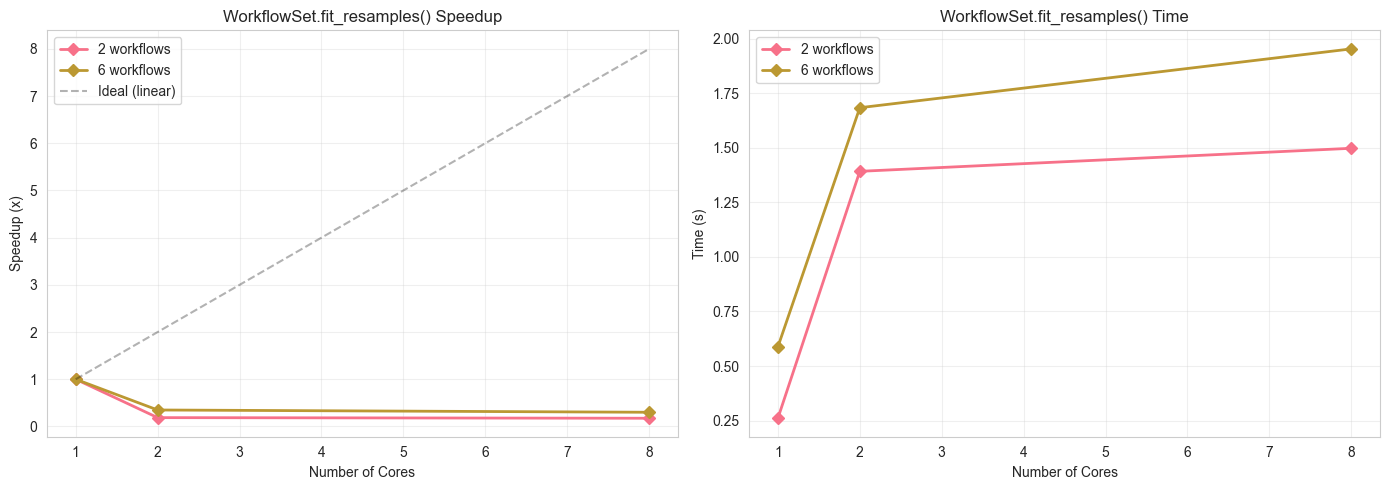

In [22]:
# Combine and visualize
bench_wfset = pd.concat([bench_wfset_small, bench_wfset_large], ignore_index=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Speedup comparison
for scenario in ['2 workflows', '6 workflows']:
    data = bench_wfset[bench_wfset['scenario'] == scenario]
    ax1.plot(data['actual_cores'], data['speedup'], marker='D', label=scenario, linewidth=2)

ax1.plot([1, cpu_count], [1, cpu_count], 'k--', alpha=0.3, label='Ideal (linear)')
ax1.set_xlabel('Number of Cores')
ax1.set_ylabel('Speedup (x)')
ax1.set_title('WorkflowSet.fit_resamples() Speedup')
ax1.legend()
ax1.grid(alpha=0.3)

# Time comparison
for scenario in ['2 workflows', '6 workflows']:
    data = bench_wfset[bench_wfset['scenario'] == scenario]
    ax2.plot(data['actual_cores'], data['time'], marker='D', label=scenario, linewidth=2)

ax2.set_xlabel('Number of Cores')
ax2.set_ylabel('Time (s)')
ax2.set_title('WorkflowSet.fit_resamples() Time')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Part 5: Comprehensive Comparison

In [23]:
# Extract parallel (all cores) results for comparison
comparison_data = []

for bench, method in [
    (bench_resample_5, 'fit_resamples (5-fold)'),
    (bench_resample_10, 'fit_resamples (10-fold)'),
    (bench_tune_small, 'tune_grid (9 configs)'),
    (bench_tune_medium, 'tune_grid (25 configs)'),
    (bench_nested_4, 'fit_nested (4 groups)'),
    (bench_nested_8, 'fit_nested (8 groups)'),
    (bench_wfset_small, 'WorkflowSet (2 wf)'),
    (bench_wfset_large, 'WorkflowSet (6 wf)')
]:
    parallel_row = bench[bench['n_jobs'] == -1].iloc[0]
    comparison_data.append({
        'Method': method,
        'Sequential Time (s)': bench[bench['n_jobs'] == 1].iloc[0]['time'],
        'Parallel Time (s)': parallel_row['time'],
        'Speedup': parallel_row['speedup'],
        'Efficiency (%)': parallel_row['efficiency']
    })

comparison_df = pd.DataFrame(comparison_data)

print(f"\nComprehensive Parallel Performance Summary (n_jobs=-1, {cpu_count} cores):")
display(comparison_df.round(2))

NameError: name 'bench_nested_4' is not defined

In [ ]:
# Visualize comprehensive comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Speedup by method
axes[0, 0].barh(comparison_df['Method'], comparison_df['Speedup'], color='steelblue', alpha=0.7)
axes[0, 0].axvline(x=1, color='r', linestyle='--', label='Baseline')
axes[0, 0].set_xlabel('Speedup (x)')
axes[0, 0].set_title('Speedup by Method')
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Efficiency by method
axes[0, 1].barh(comparison_df['Method'], comparison_df['Efficiency (%)'], color='coral', alpha=0.7)
axes[0, 1].axvline(x=100, color='r', linestyle='--', label='Ideal (100%)')
axes[0, 1].set_xlabel('Efficiency (%)')
axes[0, 1].set_title('Efficiency by Method')
axes[0, 1].legend()
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Sequential vs Parallel time
x = np.arange(len(comparison_df))
width = 0.35
axes[1, 0].bar(x - width/2, comparison_df['Sequential Time (s)'], width, label='Sequential', alpha=0.7)
axes[1, 0].bar(x + width/2, comparison_df['Parallel Time (s)'], width, label='Parallel', alpha=0.7)
axes[1, 0].set_ylabel('Time (s)')
axes[1, 0].set_title('Sequential vs Parallel Time')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(range(1, len(comparison_df) + 1))
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Speedup vs Efficiency scatter
axes[1, 1].scatter(comparison_df['Speedup'], comparison_df['Efficiency (%)'], 
                   s=100, c=range(len(comparison_df)), cmap='viridis', alpha=0.7)
axes[1, 1].set_xlabel('Speedup (x)')
axes[1, 1].set_ylabel('Efficiency (%)')
axes[1, 1].set_title('Speedup vs Efficiency')
axes[1, 1].grid(alpha=0.3)

# Add method labels to scatter
for i, txt in enumerate(comparison_df['Method']):
    axes[1, 1].annotate(i+1, 
                       (comparison_df['Speedup'].iloc[i], comparison_df['Efficiency (%)'].iloc[i]),
                       fontsize=9, ha='center')

plt.tight_layout()
plt.show()

# Print legend
print("\nMethod Index:")
for i, method in enumerate(comparison_df['Method'], 1):
    print(f"  {i}. {method}")

## Part 6: Best Practices and Decision Framework

In [ ]:
# Calculate key insights
avg_speedup = comparison_df['Speedup'].mean()
avg_efficiency = comparison_df['Efficiency (%)'].mean()
best_speedup_method = comparison_df.loc[comparison_df['Speedup'].idxmax(), 'Method']
best_efficiency_method = comparison_df.loc[comparison_df['Efficiency (%)'].idxmax(), 'Method']

print("=" * 80)
print("PARALLEL PROCESSING BENCHMARKING SUMMARY")
print("=" * 80)
print(f"\nSystem: {cpu_count} CPU cores")
print(f"\nKey Performance Metrics (n_jobs=-1):")
print(f"  Average Speedup: {avg_speedup:.2f}x")
print(f"  Average Efficiency: {avg_efficiency:.1f}%")
print(f"  Best Speedup: {best_speedup_method} ({comparison_df['Speedup'].max():.2f}x)")
print(f"  Best Efficiency: {best_efficiency_method} ({comparison_df['Efficiency (%)'].max():.1f}%)")

print("\n" + "=" * 80)
print("DECISION FRAMEWORK: WHEN TO USE PARALLEL PROCESSING")
print("=" * 80)

print("\n✅ HIGHLY RECOMMENDED (Expected speedup > 2x):")
print("   - WorkflowSet with many workflows (>4)")
print("   - Grid search with many configs (>20)")
print("   - Nested modeling with many groups (>6)")
print("   - CV with many folds (>8)")
print("   - Complex models (random forest, boosting)")

print("\n⚠️  CONDITIONALLY RECOMMENDED (Expected speedup 1.5-2x):")
print("   - Moderate number of tasks (4-8)")
print("   - Medium CV (5-8 folds)")
print("   - Small WorkflowSet (2-4 workflows)")
print("   - Simple models with moderate data")

print("\n❌ NOT RECOMMENDED (Overhead > benefit):")
print("   - Few tasks (< number of cores)")
print("   - Very simple/fast models (<1s per fit)")
print("   - Total execution time <10 seconds")
print("   - Debugging/development phase")

print("\n" + "=" * 80)
print("OPTIMAL n_jobs SELECTION")
print("=" * 80)
print("\n1. For most cases: n_jobs=-1 (use all cores)")
print("2. For shared machines: n_jobs=cpu_count-1 (leave 1 core free)")
print("3. For few tasks: n_jobs=min(task_count, cpu_count)")
print("4. For debugging: n_jobs=1 (easier error tracing)")

print("\n" + "=" * 80)
print("PERFORMANCE TIPS")
print("=" * 80)
print("\n1. Monitor with verbose=True to see progress")
print("2. Watch for CPU warnings - they help optimize")
print("3. Larger task counts → better parallel efficiency")
print("4. Complex models benefit more from parallelization")
print("5. Avoid nested parallelism (outer method controls n_jobs)")
print("6. On Windows: 'loky' backend works seamlessly")
print("7. Overhead ~0.5-1s per worker - factor into decisions")

print("\n" + "=" * 80)
print("EXPECTED SPEEDUP BY SCENARIO")
print("=" * 80)
print(f"\nBased on {cpu_count}-core system:")
for _, row in comparison_df.iterrows():
    print(f"  {row['Method']:30s}: {row['Speedup']:.2f}x (efficiency: {row['Efficiency (%)']:.1f}%)")

print("\n" + "=" * 80)